Epoch 1: Loss = 1.6692
Epoch 2: Loss = 1.3894
Epoch 3: Loss = 1.0302
Epoch 4: Loss = 0.9376
Epoch 5: Loss = 0.9107
Epoch 6: Loss = 0.8977
Epoch 7: Loss = 0.8759
Epoch 8: Loss = 0.8784
Epoch 9: Loss = 0.8523
Epoch 10: Loss = 0.8421
Epoch 11: Loss = 0.8374
Epoch 12: Loss = 0.8367
Epoch 13: Loss = 0.8402
Epoch 14: Loss = 0.8463
Epoch 15: Loss = 0.8401
Epoch 16: Loss = 0.8420
Epoch 17: Loss = 0.8432
Epoch 18: Loss = 0.8394
Epoch 19: Loss = 0.8223
Epoch 20: Loss = 0.8245
Pixel-level AUROC: 0.7795
Image-level AUROC: 0.6464


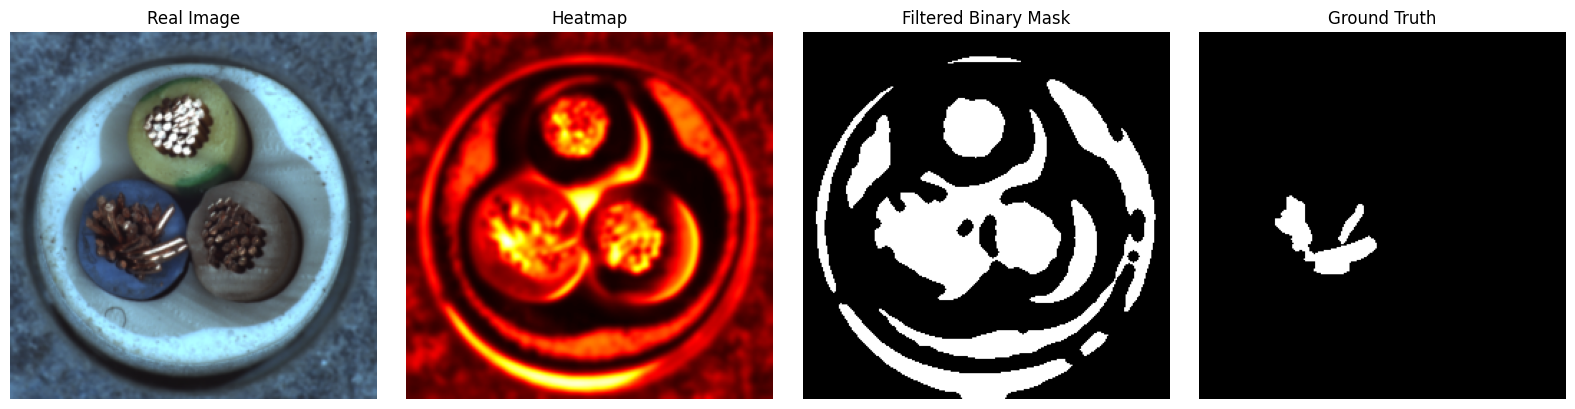

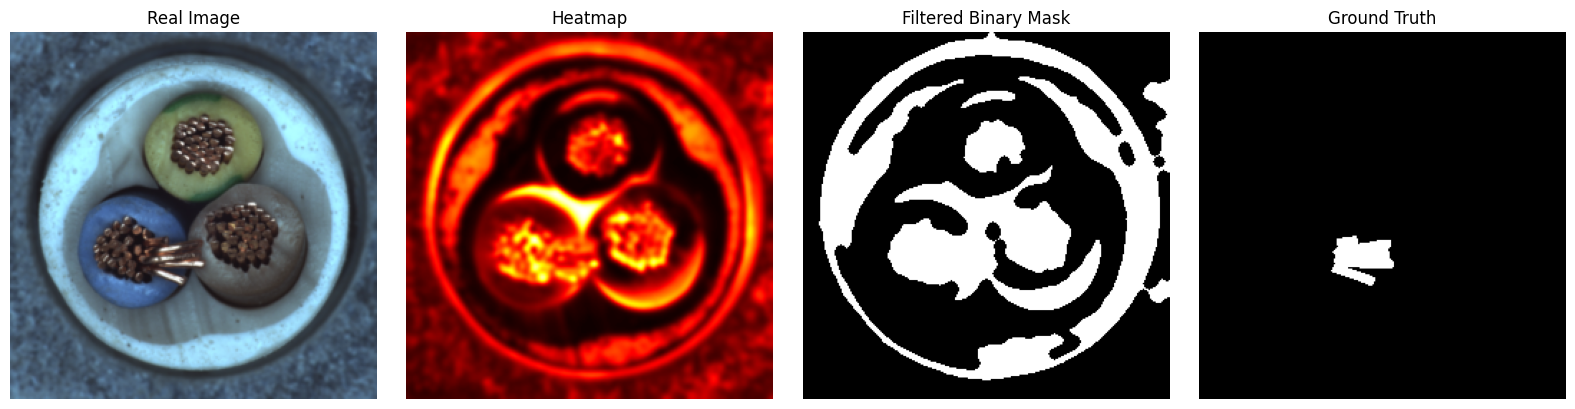

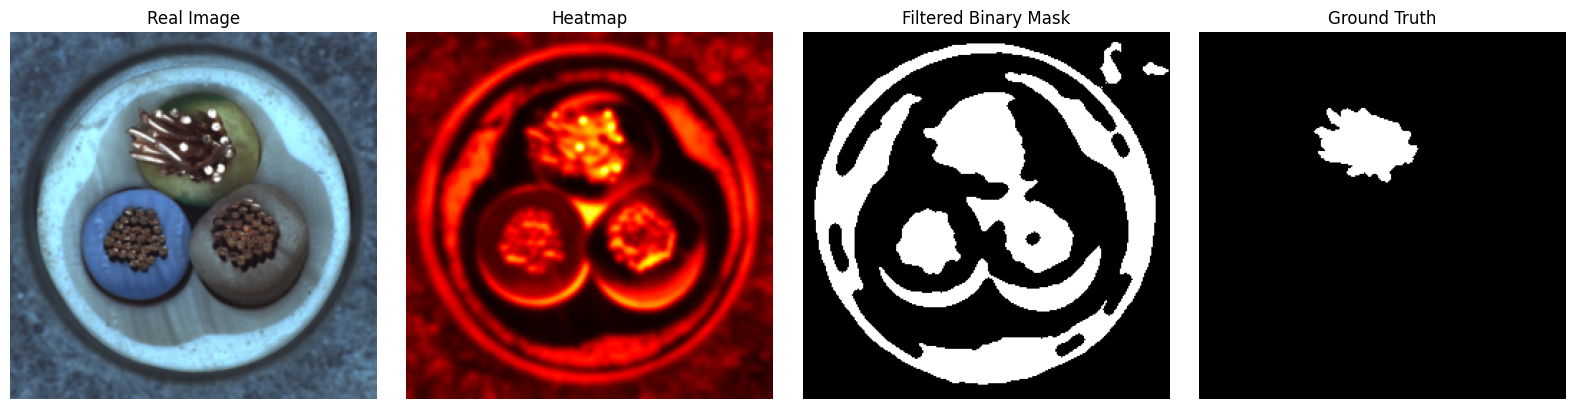

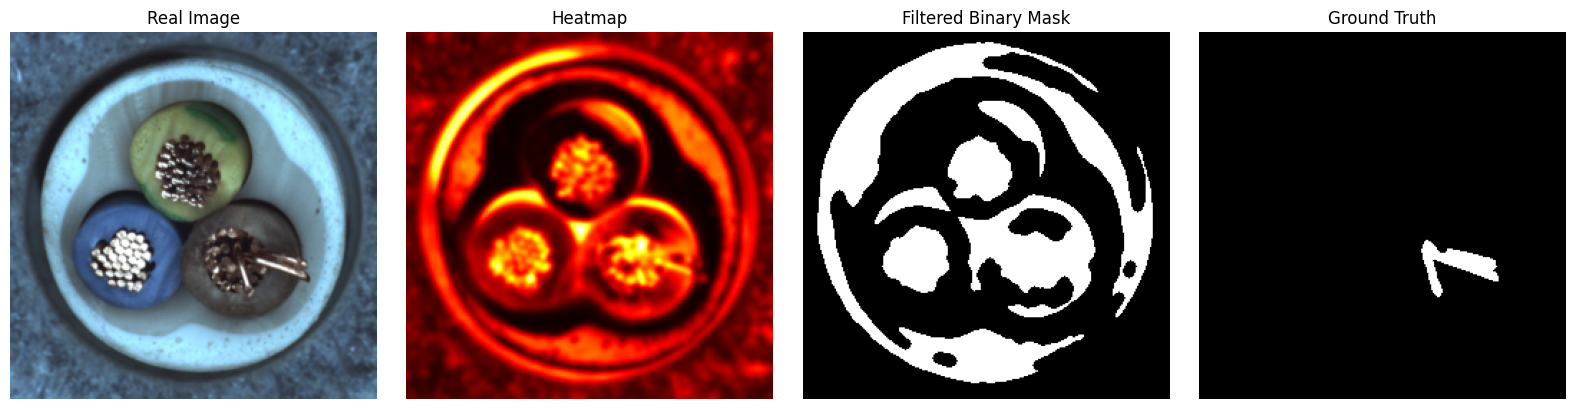

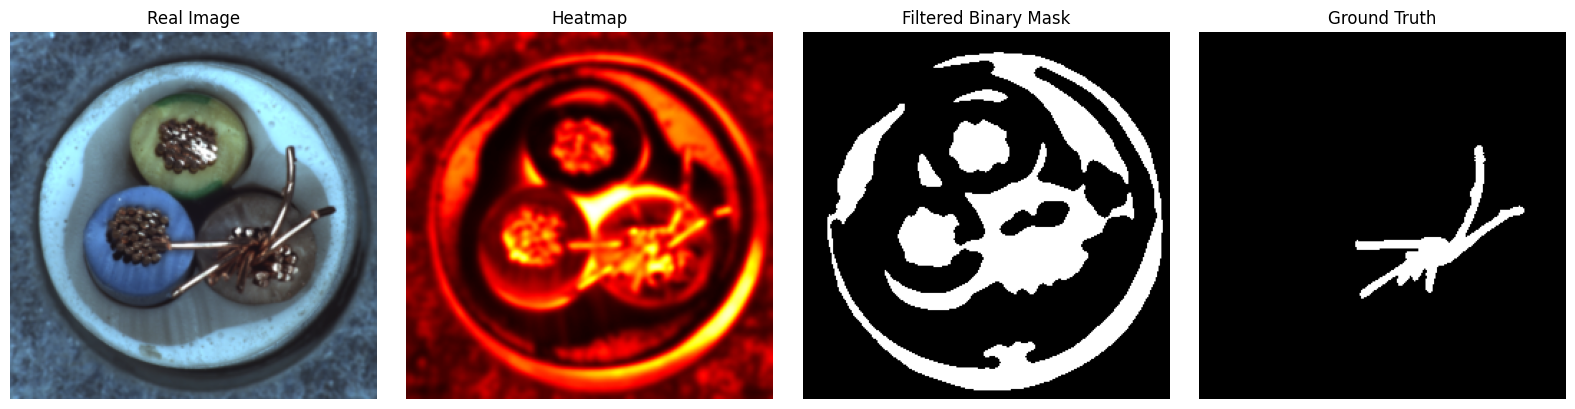

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from skimage.filters import threshold_otsu
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter
from skimage import morphology
import matplotlib.pyplot as plt

# 1. Dataset Loader
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, phase='train', transform=None, augment=False):
        self.phase = phase
        self.image_dir = os.path.join(root_dir, category, phase)
        self.gt_dir = os.path.join(root_dir, category, 'ground_truth')
        self.augment = augment

        self.img_paths = []
        self.mask_paths = []

        for defect_type in os.listdir(self.image_dir):
            defect_img_dir = os.path.join(self.image_dir, defect_type)
            if not os.path.isdir(defect_img_dir):
                continue
            for img_name in os.listdir(defect_img_dir):
                img_path = os.path.join(defect_img_dir, img_name)
                self.img_paths.append(img_path)
                if self.phase == 'test' and defect_type != 'good':
                    mask_name = img_name.replace('.png', '_mask.png')
                    self.mask_paths.append(os.path.join(self.gt_dir, defect_type, mask_name))
                else:
                    self.mask_paths.append(None)

        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('RGB')
        if self.phase == 'train' and self.augment:
            image = self.augment_transform(image)
        image = self.transform(image)

        mask = torch.zeros((1, 256, 256))
        if self.phase == 'test' and mask_path and os.path.exists(mask_path):
            mask_img = Image.open(mask_path).convert('L').resize((256, 256))
            mask = transforms.ToTensor()(mask_img)
            mask = (mask > 0.5).float()

        label = 0 if 'good' in img_path else 1
        return image, mask, label

# 2. Model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# 3. Training
def train_model(model, loader, device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    for epoch in range(20):
        total_loss = 0
        for images, _, _ in loader:
            images = images.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")

# 4. Evaluation + Heatmap Filtering
def evaluate_model(model, loader, device):
    model.eval()
    maps, masks, labels, imgs = [], [], [], []
    with torch.no_grad():
        for img, mask, label in loader:
            img = img.to(device)
            recon = model(img)
            diff_map = torch.mean((img - recon) ** 2, dim=1, keepdim=True)
            diff_map = diff_map.cpu().numpy()[0, 0]

            # === Apply filtering to clean up heatmap ===
            diff_map = gaussian_filter(diff_map, sigma=2)
            maps.append(diff_map)
            masks.append(mask.numpy()[0, 0])
            labels.append(label.item())

            # Recover original image for visualization
            img_np = img.cpu().numpy()[0].transpose(1, 2, 0)
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
            imgs.append(img_np)

    # Pixel-wise AUROC
    flat_scores = np.concatenate([m.flatten() for m in maps])
    flat_masks = np.concatenate([m.flatten() for m in masks])
    pixel_auc = roc_auc_score(flat_masks, flat_scores)

    # Image-level AUROC
    image_auc = roc_auc_score(labels, [np.max(m) for m in maps])

    print(f"Pixel-level AUROC: {pixel_auc:.4f}")
    print(f"Image-level AUROC: {image_auc:.4f}")
    return maps, masks, imgs

# 5. Full Pipeline
def run_pipeline():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    category = 'cable'  # You can change this
    dataset_path = 'MVTecDataset/Dataset'

    train_set = MVTecDataset(dataset_path, category, 'train', augment=True)
    test_set = MVTecDataset(dataset_path, category, 'test')
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

    model = ConvAutoencoder().to(device)
    train_model(model, train_loader, device)
    maps, masks, imgs = evaluate_model(model, test_loader, device)

    # Visualize 5 examples
    for i in range(5):
        heatmap = maps[i]
        threshold = threshold_otsu(heatmap)
        binary_mask = (heatmap > threshold).astype(np.uint8)

        # Post-processing
        binary_mask = morphology.remove_small_objects(binary_mask.astype(bool), min_size=100)
        binary_mask = morphology.binary_closing(binary_mask, morphology.disk(4))
        binary_mask = binary_mask.astype(np.uint8)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.title("Real Image")
        plt.imshow(imgs[i])
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Heatmap")
        plt.imshow(heatmap, cmap='hot')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Filtered Binary Mask")
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Ground Truth")
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_pipeline()
 